In [41]:
import datetime as dt

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns

In [2]:
plt.rcParams["figure.figsize"] = 15, 10

# Descarga de datos

In [3]:
# Se lee el csv con la lista de tickers y nos quedamos únicamente con el Symbol.
tickers_list = pd.read_csv("data/tickers_list.csv", usecols=["Symbol"])
tickers_list.index = tickers_list["Symbol"]

In [18]:
# Rango de fechas para trabajar
start_date = dt.datetime(2019, 1, 1)
end_date = dt.datetime(2021, 12, 31)

In [19]:
data = pdr.DataReader(name=tickers_list[:10], data_source="yahoo", start=start_date, end=end_date)["Adj Close"]

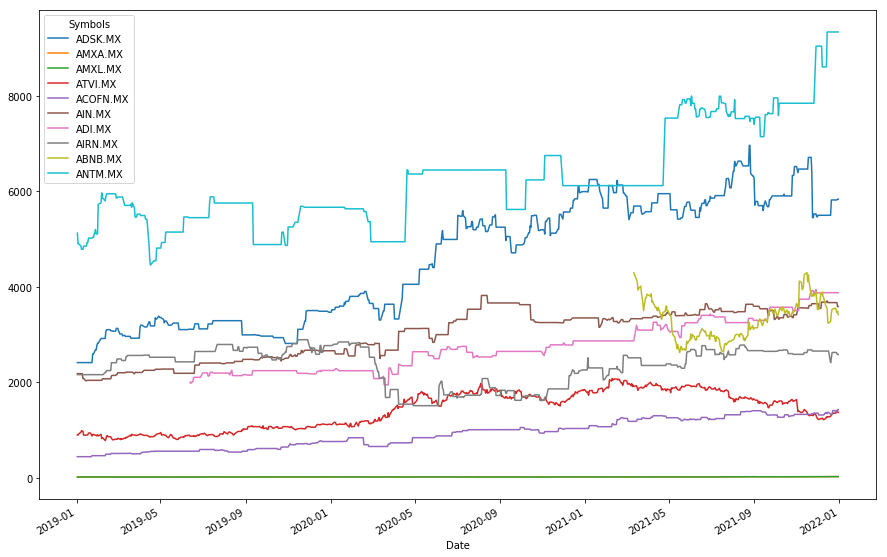

In [20]:
data.plot()

# Preprocesamiento

## Imputación de datos nulos y filtro de tickers con más del 50% de datos faltantes

In [21]:
# Se eliminan columnas duplicadas
data = data.loc[:, ~data.columns.duplicated()]

In [22]:
# Se eliminan las columnas con más del 50% de datos faltantes
nan_tickers_entries = (data.isna()).sum().to_frame()
nan_tickers_entries.columns = ["no_data"]

tickers_to_drop = nan_tickers_entries.query(f"no_data > {data.shape[0]//2}").index.to_numpy()
data.drop(tickers_to_drop, axis=1, inplace=True)

In [23]:
# Se reemplazan los Nan con ceros.
data.fillna(0, inplace=True)

In [24]:
data.tail()

Symbols,ADSK.MX,AMXA.MX,AMXL.MX,ATVI.MX,ACOFN.MX,AIN.MX,ADI.MX,AIRN.MX,ANTM.MX
Date,,,,,,,,,
2021-12-27,5821.0,21.780001,21.610001,1348.010010,1403.449951,3669.219971,3877.300049,2624.469971,9342.110352
2021-12-28,5821.0,21.760000,21.719999,1377.500000,1398.119995,3669.219971,3877.300049,2624.469971,9342.110352
2021-12-29,5821.0,21.600000,21.650000,1377.500000,1380.000000,3669.219971,3877.300049,2600.000000,9342.110352
2021-12-30,5837.0,21.059999,21.709999,1384.670044,1425.060059,3586.500000,3877.300049,2580.000000,9342.110352
2021-12-31,5837.0,21.059999,21.690001,1370.000000,1425.060059,3586.500000,3877.300049,2580.000000,9342.110352


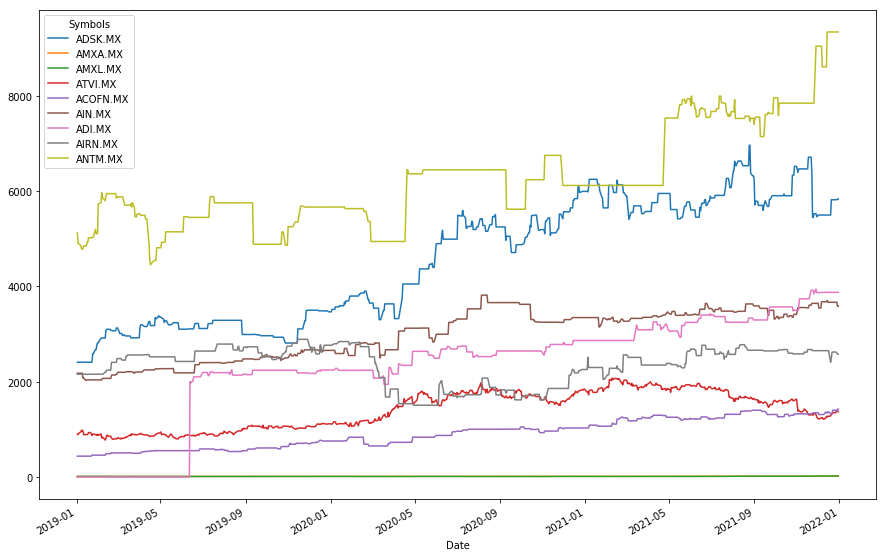

In [25]:
data.plot()

## Estandarización

In [26]:
standarized_data = (data - data.mean()) / np.sqrt( ( (data - data.mean())**2 ).sum() / (data.shape[0] - 1) )

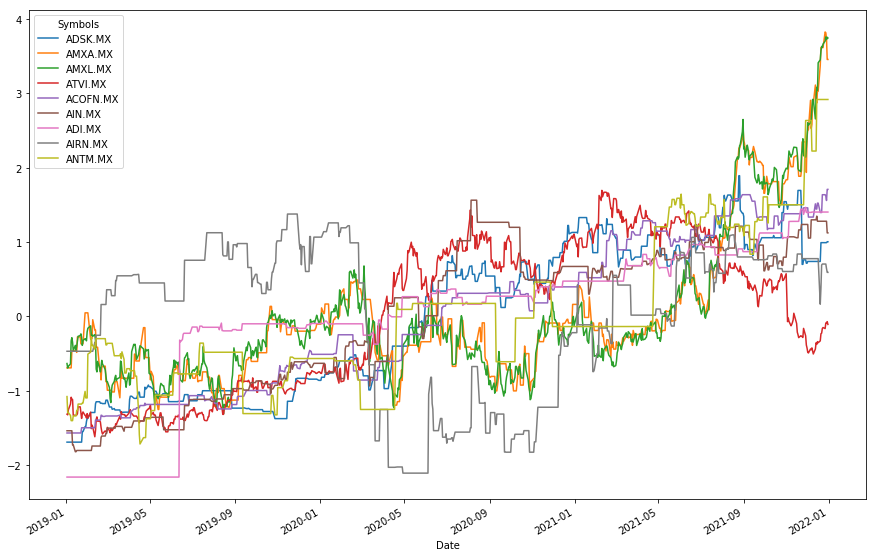

In [27]:
standarized_data.plot()

## Media móvil a 15 días

In [28]:
ma_data = data.rolling(window=15).mean()

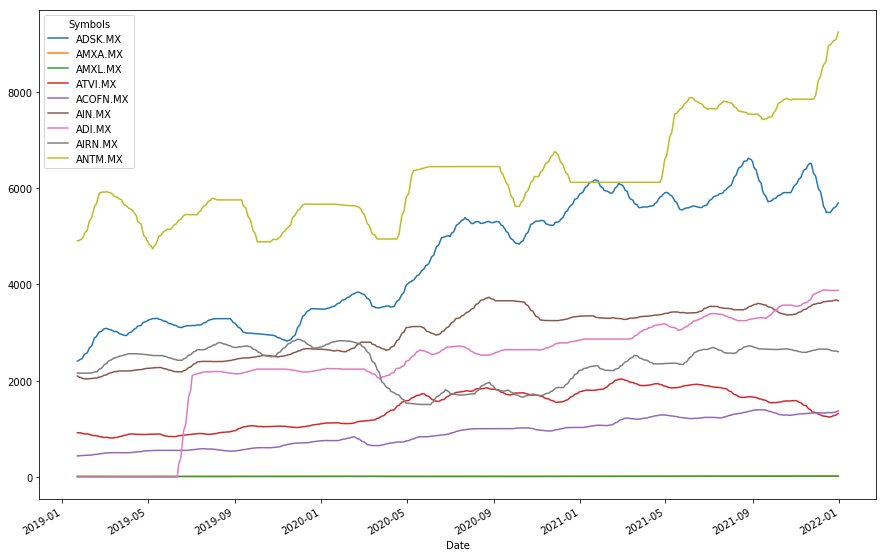

In [29]:
ma_data.plot()

## Derivada de la media móvil

In [30]:
diff_data = ma_data.diff()

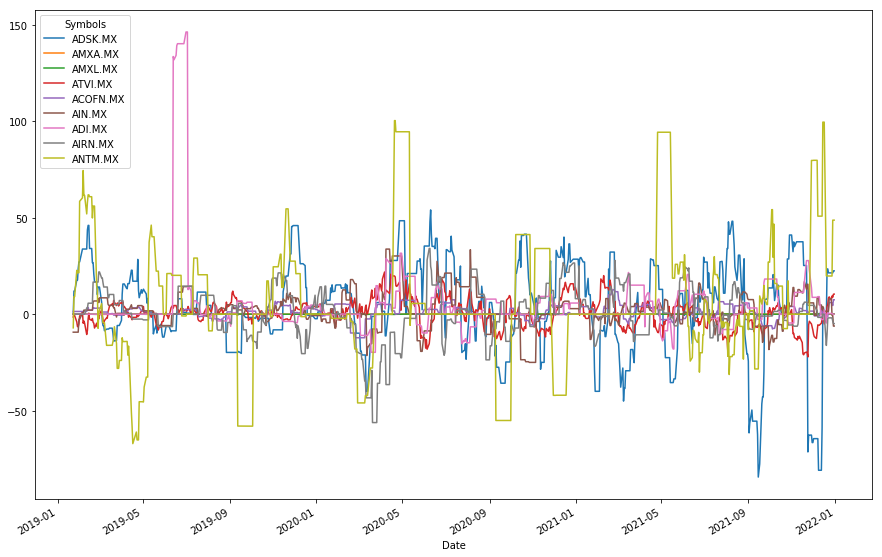

In [31]:
diff_data.plot()

# Matrices de correlación

In [32]:
corr = diff_data.corr()

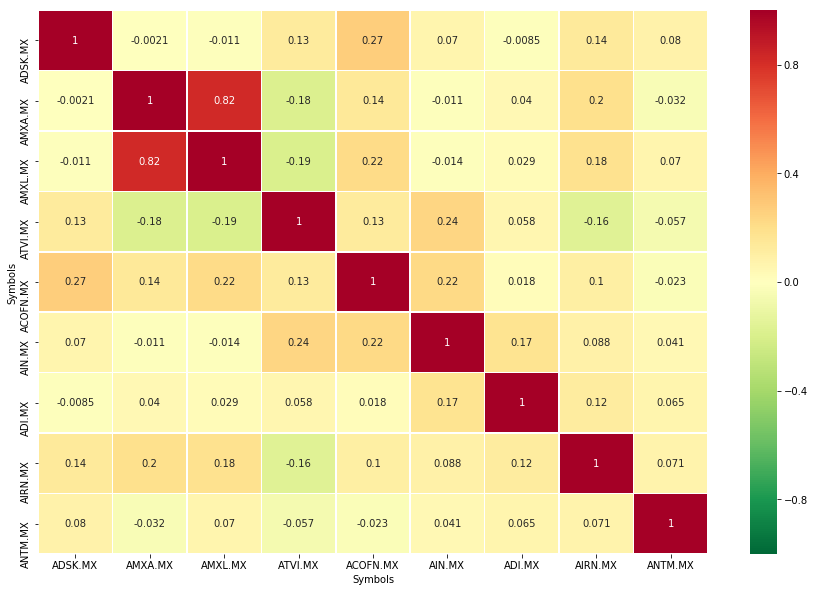

In [34]:
sns.heatmap(corr, cmap='RdYlGn_r', linewidths=0.5, annot=True, vmin=-1, vmax=1)

# Clustering jerárquico de correlaciones

In [43]:
#[stock_1, stock_2, distance, sample_count]
cluster_results = linkage(corr, 'average')

## Cophenetic Correlation

EL coeficiente de correlación cofenética es el coeficiente de correlación de Pearson entre la matriz de distancias originales y la matriz de distancias asociadas al algoritmo de clustering. Entre más cercana a uno nos indicia una mejor representación de las distancias originales bajo el modelo de clasificación. Regularmente un coeficiente mayor a 0.7 es considerado como aceptable.

In [42]:
c, coph_dists = cophenet(cluster_results, pdist(corr))
c

0.8537765415792938

## Dendograma

In [ ]:
fig = plt.figure()


plt.title('Dendograma de lustering jerárquico para los tickers en México', fontsize=20)
plt.xlabel('stock', fontsize=20)
plt.ylabel('distancia', fontsize=20)
dendrogram(
    cluster_results,
    leaf_rotation=90,  
    leaf_font_size=8,
    labels = corr.columns
)
fig.yticks(fontsize=15)
fig.xticks(rotation=-90, fontsize=15)
#plt.savefig('img/dendogram_'+index+'.png')
plt.show()

# Matriz de distancia

$d_{ij} = \sqrt{2(1-\rho_{ij})}$

Text(0.5, 1.0, 'correlación vs distancia')

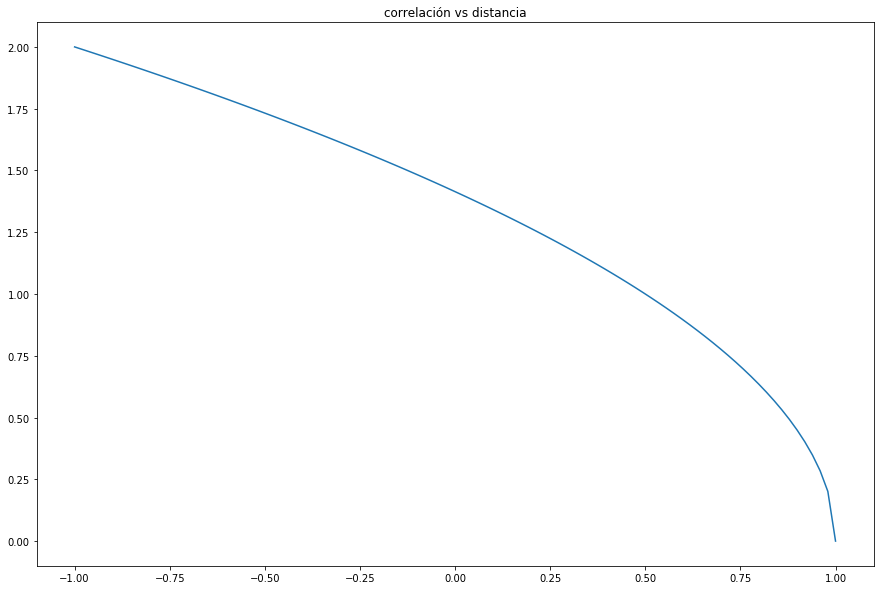

In [35]:
x = np.linspace(-1,1,100)
plt.plot(x, np.sqrt(2*(1-x)))
plt.title("correlación vs distancia")

In [36]:
dist_matrix = np.sqrt(2*(1-corr))

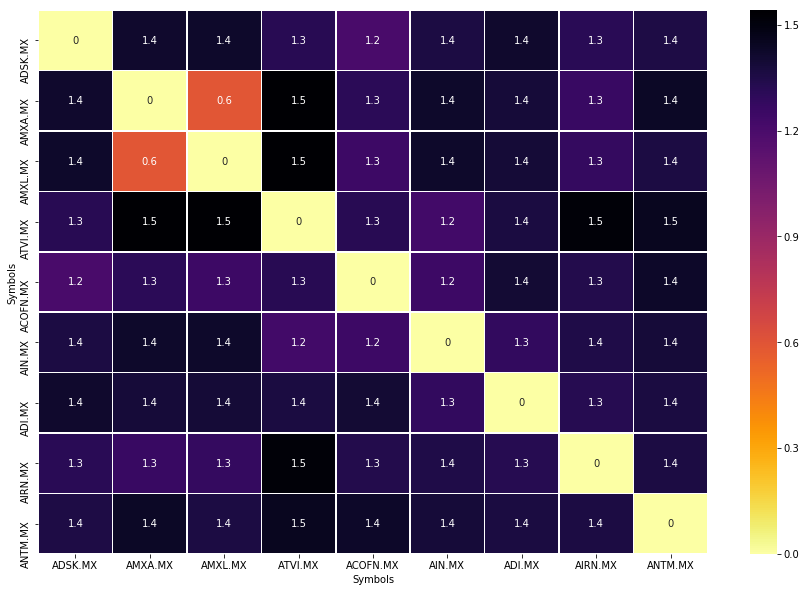

In [38]:
sns.heatmap(dist_matrix, cmap='inferno_r', linewidths=0.5, annot=True)